In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#### Parameters

In [2]:
N_CLUSTERS = 10
AVG_N = 20
NOISE_FACTOR = 0.0001
M_CLUSTERS = 100

#### Load the data 
Convert the data into a dictionary where the index is the key. This helps us to retain some sort of indexing while processing it as an RDD. <br/>
For the RDD, we pass the data as a list of tuples, where the first element is the index and the second element is the data

In [3]:
data = np.load( "100d_circle.npy" )[:40000]
np.random.shuffle( data )
data += NOISE_FACTOR * np.random.normal( loc=0, scale=1, size=data.shape )
data =  dict( list( enumerate( data ) ) ) 
rdd_data = sc.parallelize( data.items(), 4 )

In [4]:
centroid_index = np.random.randint( 0, len(data) )
centroids = [ data[centroid_index] ] #Initialize a random centroid
avg_distances = []

#### Distance between a data point and centroids 
Compute the squared distance between a data point and all the centroids we have initialized till now

In [5]:
def distFromCentroids( datum ):
    return  np.min( np.sum( np.square( datum - np.asarray(centroids) ), axis=1 ) )

#### Compute centroids 
* For each partition, <code>glom</code> the data and:
    * Initialize one centroid for each partition using KMeans++
    * Return the partition index along with the centroid index

In [6]:
def getCentroids( partition_idx, itr ):
    '''idx: partition index; itr: iterator over partition'''
    glom_data = list(itr)[0]
    idx, data = zip(*glom_data) #Chunk
    centroidDist = map( distFromCentroids, data )
    normDist = np.asarray( centroidDist / sum(centroidDist) ).cumsum().tolist()
    normDistData = zip(idx,normDist)
    randProb = np.random.random()
    select_idx, _ = filter( lambda x: randProb <= x[1], normDistData )[0]
    yield ( partition_idx, select_idx )

In [7]:
centroids = rdd_data.glom().mapPartitionsWithIndex( getCentroids ).collect()
centroid_dict = dict( (k,data[v]) for k,v in centroids )
centroids = centroid_dict.values()

#### Compute avg distance for each partition
* For each partition, identified by the partition index:
    * Get all the points that are closest to the centroid corresponding to the partition
    * Run KMeans++ on these points to get M centroids
    * Compute the average distance over these M centroids

In [8]:
def getAvgDist( partition_idx, itr ):
    '''idx: partition index; itr: iterator over partition'''
    ''' We have access to centroid_dict'''
    
    '''Get closest data points'''
    glom_data = list(itr)[0]
    idx, data = zip(*glom_data) #Chunk
    c_idx = centroid_dict.keys().index( partition_idx )
    getArgmin = lambda datum: np.argmin( np.sum( np.square( datum - np.asarray(centroids) ), axis=1 ) )
    argmin_arr = np.asarray( map( getArgmin, data ) )
    cluster_data = np.asarray( data )[ argmin_arr == c_idx ]
    cluster_idx = np.asarray( idx )[ argmin_arr == c_idx ]
    '''Run KMeans++ on the closest data points'''
    random_idx = np.random.randint( 0, len(cluster_data) )
    cluster_centroids = [ cluster_data[ random_idx ] ]
    avg_distances = []
    while( len(cluster_centroids) < M_CLUSTERS ):
        distFromCentroids = lambda datum: np.min( np.sum( np.square( datum - np.asarray(cluster_centroids) ), axis=1 ) )
        centroidDist = map( distFromCentroids, cluster_data )
        avg_distances.append( np.mean( centroidDist[::-2][:AVG_N] ) )
        normDist = np.asarray( centroidDist / sum(centroidDist) ).cumsum()
        randProb = np.random.random()
        select_idx = np.where( normDist >= randProb )[0][0]
        cluster_centroids.append( cluster_data[ select_idx ] )
    yield avg_distances


In [9]:
avg_distances = rdd_data.glom().mapPartitionsWithIndex( getAvgDist ).collect()

#### Visualize log-log plot of the average distance vs. M for each partition

In [10]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
fig = plt.figure()
gs = gridspec.GridSpec(2,2)
ax = [ fig.add_subplot(gs[i]) for i in range( len(avg_distances) ) ]
for i,val in enumerate(avg_distances):
    avg_dist = val 
    ax[i].plot( np.log2( range( 1, len(avg_dist)+1 ) ), np.log2( avg_dist ) )
    ax[i].set_xlabel( "log2(k)" )
    ax[i].set_ylabel( "log2(epsilon)" )
plt.savefig("log-log_plots.png")

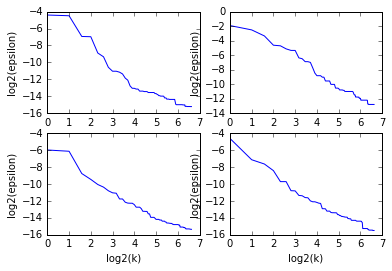

In [11]:
plt.show()